In [1]:
# -*- coding: utf-8 -*-
"""
Training an image classifier
----------------------------
We will do the following steps in order:
1. Load and normalizing the MNIST training and test datasets using
   ``torchvision``
2. Define a nearest neighbor classifier
3. Test the model on the test data (There is no training step for nearest neighbor classifier).
1. Loading and normalizing MNIST
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Using ``torchvision``, it’s extremely easy to load MNIST.
"""
import os
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import itertools

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
# .. note::
#     If running on Windows and you get a BrokenPipeError, try setting
#     the num_worker of torch.utils.data.DataLoader() to 0.

In [2]:
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=60000,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


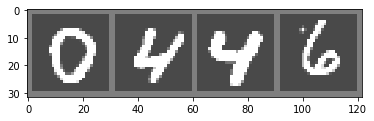

    0     4     4     6


In [4]:
########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# get some random training images
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

# show images
imshow(torchvision.utils.make_grid(example_data[:4]))

# print labels
print(' '.join('%5s' % classes[example_targets[j]] for j in range(4)))

In [21]:
########################################################################
# 2. Define a nearest neighbor model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.database_x = example_data.reshape(60000, 28*28).to(pytorch_device)
        self.database_y = example_targets.to(pytorch_device)

    def forward(self, x):
        # shape of input (=x): [16, 1, 28, 28]
        # shape of output: [16]
        # output can take on integers in [0, 9]
        
        prediction = []
        
        x = x.view(-1, 1 * 28 * 28)
        for j in range(x.shape[0]):
            distances = torch.norm( (x[j].repeat(1,self.database_x.shape[0]).view(self.database_x.shape[0],-1) - self.database_x), 1, -1)
            ind = torch.sort(distances.flatten()).indices
            #print(ind)
            prediction.append(self.database_y[ind[0]])
        return prediction

model = Model().to(pytorch_device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


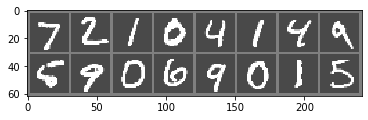

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
x.shape:  torch.Size([16, 784])
self.database_x.shape:  torch.Size([60000, 784])
Predicted:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5


In [16]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the nearest neighbor model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
#
# We will check this by predicting the class label that the nearest neighbor model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the nearest neighbor model thinks these examples above are:
outputs = model(images)

predicted = outputs
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

In [22]:
########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        predicted = outputs
        total += labels.size(0)
        correct += (torch.Tensor(predicted).to(pytorch_device) == labels).sum().item()

        c = (torch.Tensor(predicted).to(pytorch_device) == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the model on the 10000 test images: 96 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 95 %
Accuracy of     3 : 95 %
Accuracy of     4 : 95 %
Accuracy of     5 : 95 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 91 %
Accuracy of     9 : 95 %


In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",\
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 973    2    1    0    0    1    2    1    0    0]
 [   0 1129    3    0    1    1    1    0    0    0]
 [   9    8  987    6    1    0    2   17    2    0]
 [   0    2    4  965    1   21    0    9    4    4]
 [   1    9    0    0  937    0    3    4    1   27]
 [   2    1    0   17    2  848    9    1    5    7]
 [   5    2    1    0    2    5  943    0    0    0]
 [   0   20    4    2    4    0    0  989    0    9]
 [   9    5    6   21    4   18    3    4  894   10]
 [   1    5    1    7   13    5    1    9    1  966]]


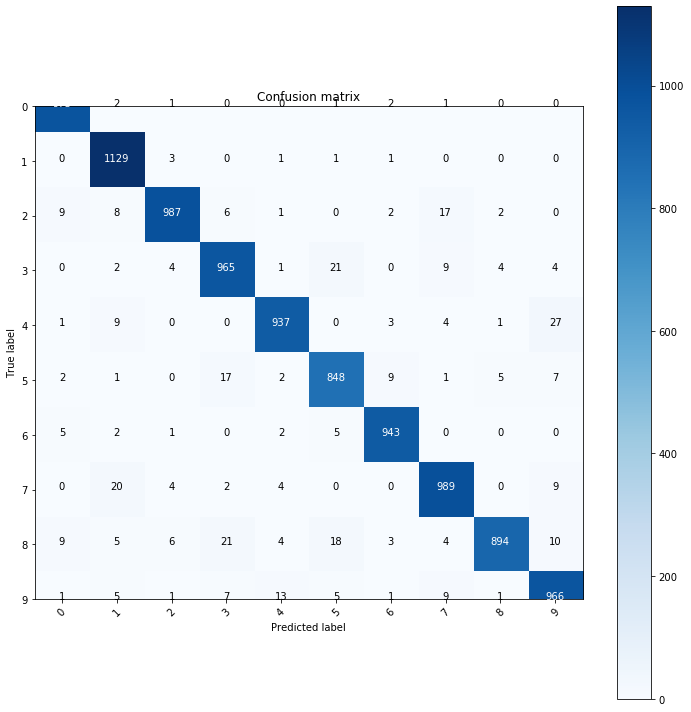

In [19]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt.numpy(), classes)

### Experiment with hyperparameters

#### Cosine similarity distance

In [29]:
########################################################################
# 2. Define a nearest neighbor model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.database_x = example_data.reshape(60000, 28*28).to(pytorch_device)
        self.database_y = example_targets.to(pytorch_device)

    def forward(self, x):
        # shape of input (=x): [16, 1, 28, 28]
        # shape of output: [16]
        # output can take on integers in [0, 9]
        
        prediction = []
        
        x = x.view(-1, 1 * 28 * 28)
        for j in range(x.shape[0]):
            distances = cos( x[j].repeat(1,self.database_x.shape[0]).view(self.database_x.shape[0],-1) ,\
                            self.database_x)
            ind = torch.sort(distances.flatten()).indices
            #print(ind)
            prediction.append(self.database_y[ind[-1]])
        return prediction

model = Model().to(pytorch_device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


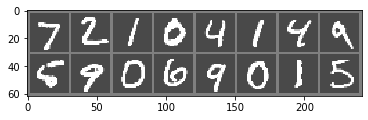

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5


In [30]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the nearest neighbor model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
#
# We will check this by predicting the class label that the nearest neighbor model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the nearest neighbor model thinks these examples above are:
outputs = model(images)

predicted = outputs
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

In [31]:
########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        predicted = outputs
        total += labels.size(0)
        correct += (torch.Tensor(predicted).to(pytorch_device) == labels).sum().item()

        c = (torch.Tensor(predicted).to(pytorch_device) == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the model on the 10000 test images: 97 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 96 %
Accuracy of     3 : 96 %
Accuracy of     4 : 95 %
Accuracy of     5 : 95 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 95 %
Accuracy of     9 : 95 %


Confusion matrix, without normalization
[[ 975    1    1    0    0    0    2    1    0    0]
 [   0 1128    3    1    1    1    1    0    0    0]
 [  10    0  999    5    1    0    2   12    3    0]
 [   0    1    1  977    1   14    0    6    6    4]
 [   1    3    0    0  941    0    6    3    1   27]
 [   1    1    0   16    1  856    8    1    4    4]
 [   5    3    0    0    2    4  944    0    0    0]
 [   1   13    5    2    2    0    0  992    0   13]
 [   6    2    1   16    4    6    5    4  926    4]
 [   5    6    1    7    9    3    1    9    3  965]]


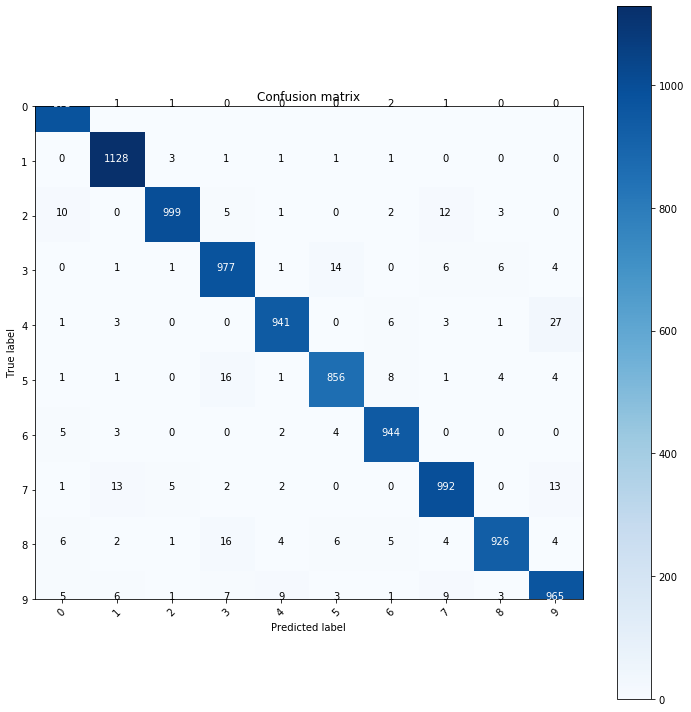

In [32]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt.numpy(), classes)

### Pairwise distance (other than 2 unlike Eucledian)

#### p = 3

In [42]:
########################################################################
# 2. Define a nearest neighbor model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
pdist = torch.nn.PairwiseDistance(p=3)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.database_x = example_data.reshape(60000, 28*28).to(pytorch_device)
        self.database_y = example_targets.to(pytorch_device)

    def forward(self, x):
        # shape of input (=x): [16, 1, 28, 28]
        # shape of output: [16]
        # output can take on integers in [0, 9]
        
        prediction = []
        
        x = x.view(-1, 1 * 28 * 28)
        for j in range(x.shape[0]):
            distances = pdist( x[j].repeat(1,self.database_x.shape[0]).view(self.database_x.shape[0],-1) ,\
                            self.database_x)
            ind = torch.sort(distances.flatten()).indices
            #print(ind)
            prediction.append(self.database_y[ind[0]])
        return prediction

model = Model().to(pytorch_device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


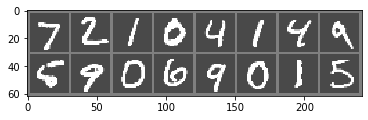

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5


In [43]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the nearest neighbor model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
#
# We will check this by predicting the class label that the nearest neighbor model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the nearest neighbor model thinks these examples above are:
outputs = model(images)

predicted = outputs
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

In [44]:
########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        predicted = outputs
        total += labels.size(0)
        correct += (torch.Tensor(predicted).to(pytorch_device) == labels).sum().item()

        c = (torch.Tensor(predicted).to(pytorch_device) == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the model on the 10000 test images: 97 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 96 %
Accuracy of     3 : 95 %
Accuracy of     4 : 96 %
Accuracy of     5 : 96 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 95 %
Accuracy of     9 : 96 %


Confusion matrix, without normalization
[[ 973    1    1    0    0    0    3    1    1    0]
 [   0 1129    3    0    1    1    1    0    0    0]
 [   6    2 1001    4    1    0    2   14    2    0]
 [   0    1    2  969    1   20    0    6    6    5]
 [   0    5    0    0  946    0    3    5    2   21]
 [   1    1    0    9    2  861    5    1    7    5]
 [   3    3    0    0    3    5  944    0    0    0]
 [   0   11    8    2    4    0    0  994    0    9]
 [   3    1    2   15    5    8    3    4  929    4]
 [   2    3    1    3   11    5    1   11    1  971]]


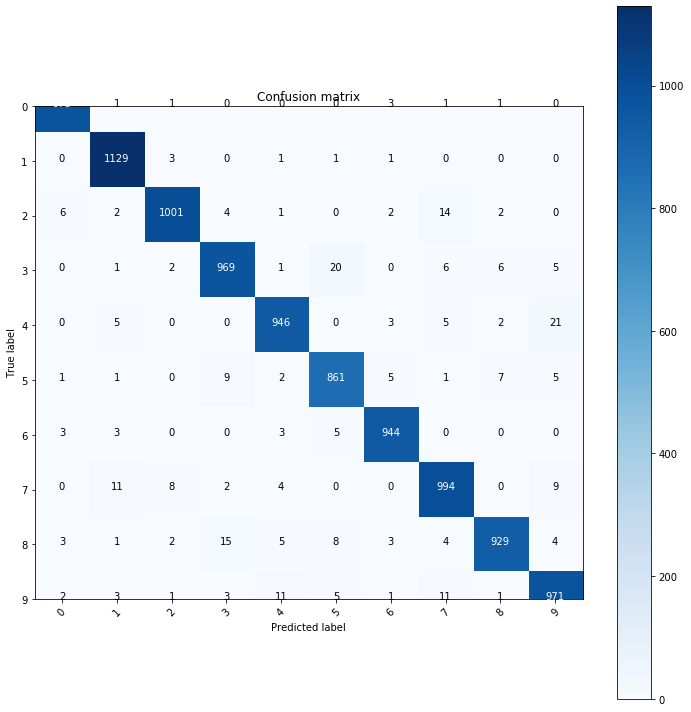

In [45]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt.numpy(), classes)

#### p = 4

In [46]:
########################################################################
# 2. Define a nearest neighbor model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
pdist = torch.nn.PairwiseDistance(p=4)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.database_x = example_data.reshape(60000, 28*28).to(pytorch_device)
        self.database_y = example_targets.to(pytorch_device)

    def forward(self, x):
        # shape of input (=x): [16, 1, 28, 28]
        # shape of output: [16]
        # output can take on integers in [0, 9]
        
        prediction = []
        
        x = x.view(-1, 1 * 28 * 28)
        for j in range(x.shape[0]):
            distances = pdist( x[j].repeat(1,self.database_x.shape[0]).view(self.database_x.shape[0],-1) ,\
                            self.database_x)
            ind = torch.sort(distances.flatten()).indices
            #print(ind)
            prediction.append(self.database_y[ind[0]])
        return prediction

model = Model().to(pytorch_device)


########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        predicted = outputs
        total += labels.size(0)
        correct += (torch.Tensor(predicted).to(pytorch_device) == labels).sum().item()

        c = (torch.Tensor(predicted).to(pytorch_device) == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the model on the 10000 test images: 97 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 95 %
Accuracy of     4 : 97 %
Accuracy of     5 : 96 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 95 %
Accuracy of     9 : 96 %


### Seems like p = 4 did slighlty better than p = 2 (and of course eucledian)